In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import wandb
import os
import glob
from topk_sae import FastAutoencoder, loss_fn, unit_norm_decoder_grad_adjustment_, unit_norm_decoder_, init_from_data_


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(ae, train_loader, optimizer, epochs, k, auxk_coef, clip_grad=None, save_dir="checkpoints", model_name=""):
    os.makedirs(save_dir, exist_ok=True)
    step = 0
    num_batches = len(train_loader)
    for epoch in range(epochs):
        ae.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            x = batch[0].to(device)
            recons, info = ae(x)
            loss, recons_loss, auxk_loss = loss_fn(ae, x, recons, info, auxk_coef)
            loss.backward()
            step += 1
            
            # calculate proportion of dead latents (not fired in last num_batches = 1 epoch)
            dead_latents_prop = (ae.stats_last_nonzero > num_batches).float().mean().item()
            
            unit_norm_decoder_grad_adjustment_(ae)
            
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(ae.parameters(), clip_grad)
            
            optimizer.step()
            unit_norm_decoder_(ae)

            topk_indices = torch.cat((info["topk_indices"], info["auxk_indices"]), dim = -1)
            selected_grad = torch.abs(ae.encoder.weight.grad[topk_indices, :]).mean()
            print('encoder', selected_grad)

            mask = torch.ones_like(ae.encoder.weight.grad)
            mask[topk_indices, :] = 0
            unselected_grad = ae.encoder.weight.grad[mask == 1].mean()
            print(unselected_grad)

            selected_dgrad = torch.abs(ae.decoder.weight.grad[:, topk_indices]).mean()
            print('decoder', selected_dgrad)
            unselected_dgrad = ae.decoder.weight.grad[mask.T == 1].mean()
            print(unselected_dgrad)
            
            print(info["topk_indices"], info["auxk_indices"])
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

        # Delete previous model saves for this configuration
        for old_model in glob.glob(os.path.join(save_dir, f"{model_name}_epoch_*.pth")):
            os.remove(old_model)

        # Save new model
        save_path = os.path.join(save_dir, f"{model_name}_epoch_{epoch+1}.pth")
        torch.save(ae.state_dict(), save_path)
        print(f"Model saved to {save_path}")

d_model = 1536
n_dirs = d_model * 6
k = 32
auxk = 64 #256
batch_size = 1024
lr = 1e-4
epochs = 1
auxk_coef = 1/32
clip_grad = 1.0

# Create model name
model_name = f"{k}_{n_dirs}_{auxk}_final"

data = np.load("../data/vector_store/abstract_embeddings.npy")
data_tensor = torch.from_numpy(data).float()
dataset = TensorDataset(data_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

ae = FastAutoencoder(n_dirs, d_model, k, auxk).to(device)
init_from_data_(ae, data_tensor[:10000].to(device))

optimizer = optim.Adam(ae.parameters(), lr=lr)

In [20]:
# print abs gradient for topk/auxk and everything else -- encoder and decoder

train(ae, train_loader, optimizer, epochs, k, auxk_coef, clip_grad, model_name=model_name)

Epoch 1/1:   0%|          | 0/266 [00:00<?, ?it/s]

encoder tensor(2.3821e-06)
tensor(0.)


Epoch 1/1:   0%|          | 1/266 [00:02<12:04,  2.74s/it]

decoder tensor(8.2407e-06)
tensor(0.)
tensor([[1273, 3291, 3617,  ..., 6987, 7294, 4997],
        [1434,  413, 6663,  ..., 7996, 6245, 4551],
        [4805, 2028, 8092,  ..., 4632, 8959, 6493],
        ...,
        [4566, 2767, 3735,  ..., 8246, 1693, 6828],
        [8525, 7525, 4393,  ..., 9006, 6486, 2325],
        [ 710, 6486, 3697,  ..., 6559, 6656, 2215]]) tensor([[1273, 3291, 3617,  ..., 6058, 1729, 3892],
        [1434,  413, 6663,  ..., 3927, 1730, 1509],
        [4805, 2028, 8092,  ..., 1634, 3011, 1343],
        ...,
        [4566, 2767, 3735,  ..., 5308, 1400, 6694],
        [8525, 7525, 4393,  ..., 1512, 1070, 1621],
        [ 710, 6486, 3697,  ..., 5435, 7022, 5553]])
encoder tensor(2.2351e-06)
tensor(0.)


Epoch 1/1:   1%|          | 2/266 [00:05<12:37,  2.87s/it]

decoder tensor(8.3414e-06)
tensor(0.)
tensor([[ 570, 6693, 4404,  ..., 3893, 2949, 5476],
        [ 728, 8980, 6828,  ..., 8309,  248, 6425],
        [8885, 5407, 1528,  ..., 8161, 1969, 4945],
        ...,
        [8070, 6884, 6568,  ..., 9131, 8666, 7245],
        [6549, 1590, 7606,  ..., 7828, 5134,  658],
        [ 805, 4388, 7948,  ...,  397, 6749, 4244]]) tensor([[ 570, 6693, 4404,  ..., 2172, 7459, 2267],
        [ 728, 8980, 6828,  ..., 6328, 5801, 4661],
        [8885, 5407, 1528,  ..., 4474, 2152, 1749],
        ...,
        [8070, 6884, 6568,  ...,  411, 7834,  681],
        [6549, 1590, 7606,  ..., 6195, 1294, 8897],
        [ 805, 4388, 7948,  ..., 5647, 8807, 2540]])
encoder tensor(2.0439e-06)
tensor(0.)


Epoch 1/1:   1%|          | 3/266 [00:08<12:23,  2.83s/it]

decoder tensor(8.1283e-06)
tensor(0.)
tensor([[7471, 4344, 3954,  ..., 2043, 1880, 8125],
        [6107, 2808, 7103,  ..., 8558, 6728, 6256],
        [2784, 6689, 6676,  ..., 7709, 4870, 3525],
        ...,
        [ 989, 8896, 3451,  ..., 2654,  157, 8169],
        [4499, 5466, 6744,  ..., 7839,  331, 9140],
        [4578, 3705, 7834,  ...,  397, 4856, 6299]]) tensor([[7471, 4344, 3954,  ...,  716, 5814, 2406],
        [6107, 2808, 7103,  ..., 8648, 4151, 1617],
        [2784, 6689, 6676,  ...,  760, 1079, 4889],
        ...,
        [ 989, 8896, 3451,  ..., 1876, 8752, 5393],
        [4499, 5466, 6744,  ..., 1636, 3791, 4281],
        [4578, 3705, 7834,  ..., 5088, 8926, 3158]])
encoder tensor(1.9335e-06)
tensor(0.)


Epoch 1/1:   2%|▏         | 4/266 [00:10<11:27,  2.62s/it]

decoder tensor(8.2458e-06)
tensor(0.)
tensor([[1762, 7172,  903,  ..., 1450, 2287, 8942],
        [ 509, 8841,  479,  ..., 3573, 7164, 4416],
        [4315, 4595, 1188,  ..., 3625, 7398, 8035],
        ...,
        [8720, 5278, 2587,  ...,  124, 4709, 7959],
        [2759, 7847, 4382,  ..., 7885, 8824, 7776],
        [7095, 7544, 6738,  ...,  422, 1099, 6900]]) tensor([[1762, 7172,  903,  ..., 9032, 1055, 5990],
        [ 509, 8841,  479,  ..., 2408, 5650, 4568],
        [4315, 4595, 1188,  ..., 7689, 2859, 8080],
        ...,
        [8720, 5278, 2587,  ..., 9039, 5331, 2130],
        [2759, 7847, 4382,  ..., 8865, 8745, 7131],
        [7095, 7544, 6738,  ..., 8863, 5417, 8851]])
encoder tensor(1.7542e-06)
tensor(0.)


Epoch 1/1:   2%|▏         | 5/266 [00:13<10:58,  2.52s/it]

decoder tensor(7.7292e-06)
tensor(0.)
tensor([[3346, 7813, 6861,  ..., 7973, 1632, 5756],
        [4798, 4326, 5524,  ..., 6667, 8822, 3499],
        [4931, 7579, 2095,  ..., 2564, 2680, 5254],
        ...,
        [1518, 2909, 8980,  ..., 3770, 5472,  367],
        [ 100, 6908, 9029,  ...,  725, 6032, 8341],
        [7099, 2471, 6630,  ...,  162, 8469, 3679]]) tensor([[3346, 7813, 6861,  ..., 4339, 3267, 7427],
        [4798, 4326, 5524,  ..., 4659, 5353, 3873],
        [4931, 7579, 2095,  ..., 2531,  962, 2131],
        ...,
        [1518, 2909, 8980,  ..., 5662, 2919, 1089],
        [ 100, 6908, 9029,  ..., 1002, 8089,  688],
        [7099, 2471, 6630,  ..., 1027,  509, 6359]])


Epoch 1/1:   2%|▏         | 5/266 [00:14<12:55,  2.97s/it]


KeyboardInterrupt: 

In [1]:
import autointerp
from pathlib import Path

%load_ext autoreload
%autoreload 2

In [7]:
!ls ../data/vector_store/

abstract_embeddings.npy documents.pkl           keyword_index.json
abstract_texts.json     embeddings_matrix.npy   metadata.json
document_index.pkl      index_mapping.pkl


In [148]:
import torch
import numpy as np
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset
from topk_sae import FastAutoencoder  # Assuming train.py contains your FastAutoencoder class

# Set grad to false
torch.set_grad_enabled(False)

# hypers
d_model = 1536
n_dirs = d_model * 6
k = 64
auxk = 128
multik = 256
batch_size = 1024

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained model
ae = FastAutoencoder(n_dirs, d_model, k, auxk, multik = multik).to(device)
#model_path = 'checkpoints/64_9216_128_256_multik_epoch_10.pth'
model_path = 'checkpoints/64_9216_128_final_epoch_44.pth'
ae.load_state_dict(torch.load(model_path))
ae.eval()

# Load abstract embeddings
abstract_embeddings = np.load("../data/vector_store/abstract_embeddings.npy")
abstract_embeddings = abstract_embeddings.astype(np.float32)

# Create a DataLoader for efficient batching
dataset = TensorDataset(torch.from_numpy(abstract_embeddings))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Prepare arrays to store results
num_abstracts = len(abstract_embeddings)
topk_indices = np.zeros((num_abstracts, k), dtype=np.int64)
topk_values = np.zeros((num_abstracts, k), dtype=np.float32)
multik_indices = np.zeros((num_abstracts, multik), dtype=np.int64)
multik_values = np.zeros((num_abstracts, multik), dtype=np.float32)
all_latents = np.zeros((num_abstracts, n_dirs), dtype=np.float32)

# Process batches
with torch.no_grad():
    for i, (batch,) in enumerate(tqdm(dataloader, desc="Processing abstracts")):
        batch = batch.to(device)
        _, info = ae(batch)
        
        start_idx = i * batch_size
        end_idx = start_idx + batch.size(0)
        
        topk_indices[start_idx:end_idx] = info['topk_indices'].cpu().numpy()
        topk_values[start_idx:end_idx] = info['topk_values'].cpu().numpy()
        multik_indices[start_idx:end_idx] = info['multik_indices'].cpu().numpy()
        multik_values[start_idx:end_idx] = info['multik_values'].cpu().numpy()
        all_latents[start_idx:end_idx] = info['latents_pre_act'].cpu().numpy()

# Create directory to save results
os.makedirs("sae_data", exist_ok=True)

# Save results
np.save("sae_data/topk_indices.npy", topk_indices)
np.save("sae_data/topk_values.npy", topk_values)

print("Processing complete. Results saved in 'sae_data' folder.")

Processing abstracts: 100%|██████████| 266/266 [01:43<00:00,  2.58it/s]


Processing complete. Results saved in 'sae_data' folder.


In [75]:
import matplotlib.pyplot as plt
import topk_sae

In [96]:
# CODE TO COMPUTE RECONSTRUCTION MSE AT DIFFERENT K VALUES

# Load the pre-trained model
ae = FastAutoencoder(n_dirs, d_model, k, auxk, multik = multik).to(device)
model_path = 'checkpoints/64_9216_128_final_epoch_44.pth'
#model_path = 'checkpoints/64_9216_128_256_multik_epoch_10.pth'
ae.load_state_dict(torch.load(model_path))
ae.eval()

with torch.no_grad():
    for i, (batch,) in enumerate(tqdm(dataloader, desc="Processing abstracts")):
        if i == 1:
            batch = batch.to(device)
            _, info = ae(batch)
            
            start_idx = i * batch_size
            end_idx = start_idx + batch.size(0)
            kvals = range(16, 256, 4)
            mse = np.zeros(len(kvals))
            
            for i, kval in enumerate(kvals):
                latents_pre_act = info['latents_pre_act']
                recon_at_k = ae.decode_at_k(latents_pre_act, kval)
                mse[i] = topk_sae.normalized_mse(recon_at_k, batch)

Processing abstracts: 100%|██████████| 266/266 [00:08<00:00, 30.81it/s] 


Text(0, 0.5, 'normalized mse, topk')

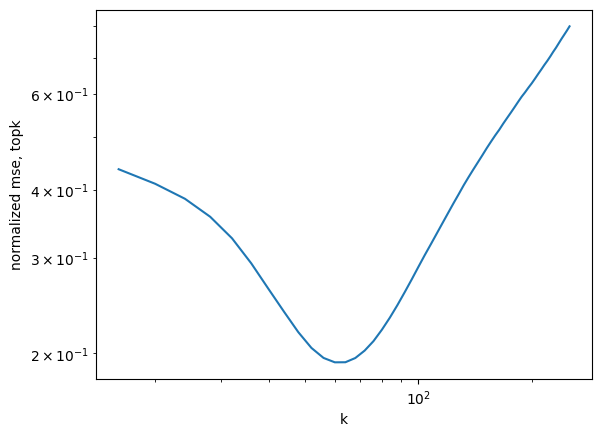

In [97]:
plt.plot(kvals, mse)
plt.yscale("log")
plt.xscale("log")
plt.xlabel('k')
plt.ylabel('normalized mse, topk')

Text(0, 0.5, 'normalized mse, multik')

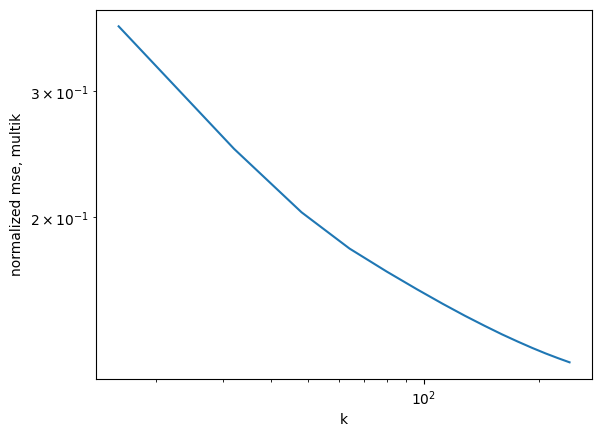

In [94]:
plt.plot(kvals, mse)
plt.yscale("log")
plt.xscale("log")
plt.xlabel('k')
plt.ylabel('normalized mse, multik')

In [71]:
copy = all_latents.copy()
for i in range(num_abstracts):
    copy[i, multik_indices[i]] = 0

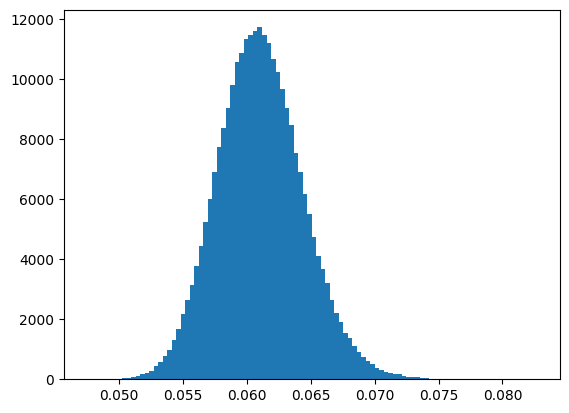

In [72]:
hist = plt.hist(np.mean(topk_values, axis = 1), bins=100) # highest activation in topk

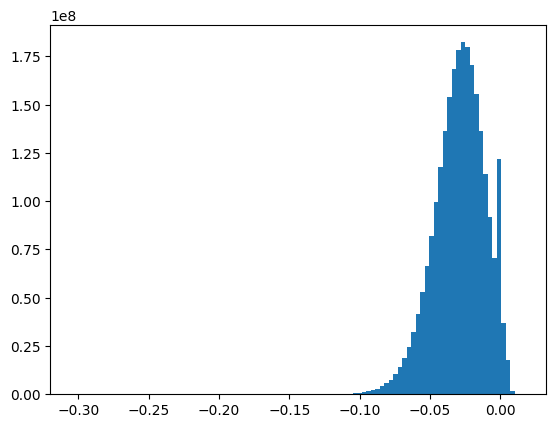

In [74]:
hist = plt.hist(copy.flatten(), bins = 100)
#plt.xlim(-0.2)
#plt.ylim(0, 100)

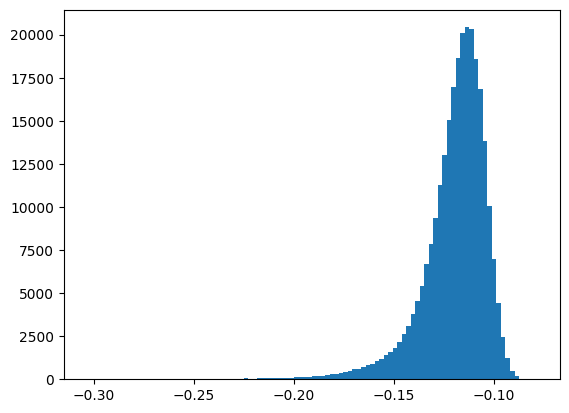

In [73]:
hist = plt.hist(np.min(copy, axis = 1), bins = 100)

In [99]:
all_latents.shape

(271494, 9216)

In [182]:
from tqdm import tqdm
def co_occurrence(topk_indices, k = 64, ndir=9216):
    co_occurrence = np.zeros((ndir, ndir))
    norms = np.zeros(ndir)
    for i in tqdm(range(topk_indices.shape[0] // 10), desc="Calculating co-occurrence"):
        for j in range(k):
            norms[topk_indices[i, j]] += 1
            for l in range(j + 1, k):
                co_occurrence[topk_indices[i, j], topk_indices[i, l]] += 1
                co_occurrence[topk_indices[i, l], topk_indices[i, j]] += 1
    
    # norms_matrix = np.outer(norms + 1, norms + 1)
    # co_occurrence = np.divide(co_occurrence, norms_matrix, where=norms_matrix!=0)

    return co_occurrence, norms

In [183]:
mat, norms = co_occurrence(topk_indices)

Calculating co-occurrence: 100%|██████████| 27149/27149 [01:07<00:00, 400.24it/s]


In [185]:
mat_vert = mat/(norms + 1)[:, None]
mat_horz = mat/(norms + 1)[None, :]

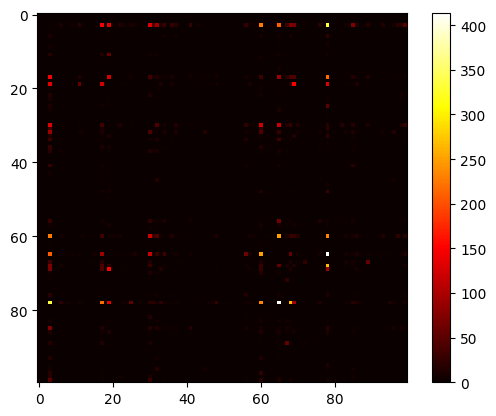

In [218]:
start = 350
end = 450

plt.imshow(mat[start:end, start:end], cmap = 'hot')
plt.colorbar()

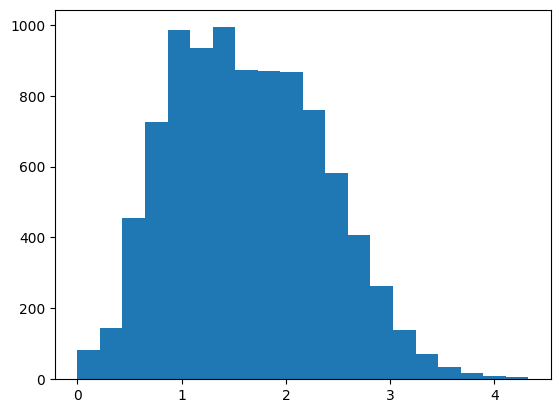

In [189]:
hist = plt.hist(np.log10(norms + 1), bins = 20)

In [147]:
import autointerp

In [192]:
CONFIG_PATH = Path("../config.yaml")
DATA_DIR = Path("../data")
SAE_DATA_DIR = Path("sae_data")
num_samples = 5
feature_index = 62

analyzer = autointerp.NeuronAnalyzer(CONFIG_PATH, feature_index, num_samples)

top_abstracts, zero_abstracts = analyzer.get_feature_activations(num_samples)
interpretation = analyzer.generate_interpretation(top_abstracts, zero_abstracts)
print(f"Interpretation: {interpretation}")

num_test_samples = 4
test_abstracts = [abstract for _, abstract, _ in top_abstracts[-num_test_samples:] + zero_abstracts[-num_test_samples:]]
ground_truth = [1] * num_test_samples + [0] * num_test_samples

predictions = analyzer.predict_activations(interpretation, test_abstracts)
correlation, f1 = analyzer.evaluate_predictions(ground_truth, predictions)

print(f"Pearson correlation: {correlation}")
print(f"F1 score: {f1}")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Interpretation: Precise measurement of astronomical constants**


100%|██████████| 8/8 [00:27<00:00,  3.42s/it]

Pearson correlation: 0.895143592549291
F1 score: 0.8888888888888888


In [193]:
test_abstracts

['["Median statistics estimates of Hubble and Newton\'s constants"]\n\nRobustness of any statistics depends upon the number of assumptions it makes about the measured data. We point out the advantages of median statistics using toy numerical experiments and demonstrate its robustness, when the number of assumptions we can make about the data are limited. We then apply the median statistics technique to obtain estimates of two constants of nature, Hubble constant (H<SUB>0</SUB>) and Newton\'s gravitational constant ( G , both of which show significant differences between different measurements. For H<SUB>0</SUB>, we update the analyses done by Chen and Ratra (2011) and Gott et al. (2001) using 576 measurements. We find after grouping the different results according to their primary type of measurement, the median estimates are given by H<SUB>0</SUB> = 72.5^{+2.5}_{-8} km/sec/Mpc with errors corresponding to 95% c.l. (2 σ) and G=6.674702^{+0.0014}_{-0.0009} × 10^{-11} Nm<SUP>2</SUP>kg<SU

In [209]:
CONFIG_PATH = Path("../config.yaml")
DATA_DIR = Path("../data")
SAE_DATA_DIR = Path("sae_data")
num_samples = 5
feature_index = 1005

analyzer = autointerp.NeuronAnalyzer(CONFIG_PATH, feature_index, num_samples)

top_abstracts, zero_abstracts = analyzer.get_feature_activations(num_samples)
# interpretation = analyzer.generate_interpretation(top_abstracts, zero_abstracts)
# print(f"Interpretation: {interpretation}")

# num_test_samples = 4
# test_abstracts = [abstract for _, abstract, _ in top_abstracts[-num_test_samples:] + zero_abstracts[-num_test_samples:]]
# ground_truth = [1] * num_test_samples + [0] * num_test_samples

# predictions = analyzer.predict_activations(interpretation, test_abstracts)
# correlation, f1 = analyzer.evaluate_predictions(ground_truth, predictions)

# print(f"Pearson correlation: {correlation}")
# print(f"F1 score: {f1}")

In [210]:
top_abstracts

[('27094346',
  "['Reducing Effects of Swath Gaps on Unsupervised Machine Learning Models for NASA MODIS Instruments']\n\nDue to the nature of their pathways, NASA Terra and NASA Aqua satellites capture imagery containing swath gaps, which are areas of no data. Swath gaps can overlap the region of interest (ROI) completely, often rendering the entire imagery unusable by Machine Learning (ML) models. This problem is further exacerbated when the ROI rarely occurs (e.g. a hurricane) and, on occurrence, is partially overlapped with a swath gap. With annotated data as supervision, a model can learn to differentiate between the area of focus and the swath gap. However, annotation is expensive and currently the vast majority of existing data is unannotated. Hence, we propose an augmentation technique that considerably removes the existence of swath gaps in order to allow CNNs to focus on the ROI, and thus successfully use data with swath gaps for training. We experiment on the UC Merced Land 

In [211]:
zero_abstracts

[('11939905',
  "['Optical physics of imaging and interferometric phased arrays']\n\nMicrowave, submillimetre-wave, and far-infrared phased arrays are of considerable importance for astronomy. We consider the behaviour imaging phased arrays and interferometric phased arrays from a functional perspective. It is shown that the average powers, field correlations, power fluctuations, and correlations between power fluctuations at the output ports of an imaging or interferometric phased array can be found once the synthesised reception patterns are known. The reception patterns do not have to be orthogonal or even linearly independent. It is shown that the operation of phased arrays is intimately related to the mathematical theory of frames, and that the theory of frames can be used to determine the degree to which any class of intensity or field distribution can be reconstructed unambiguously from the complex amplitudes of the travelling waves at the output ports. The theory can be used to

In [219]:
import pickle

ModuleNotFoundError: No module named 'vector_store'